In [57]:
# Библиотеки, которые мы будем использовать
import random
import numpy as np
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

import imgaug.augmenters as iaa
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

from torch.nn.functional import one_hot
from collections import defaultdict

In [58]:
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Изменение размера
    transforms.ToTensor(),  # Преобразование в тензор
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Нормализация
])

dataset = ImageFolder(root="Clothes_Dataset", transform=data_transform)

In [ ]:
print(f'''
Общее количество изображений: {len(dataset)}
Количество классов: {len(dataset.classes)}
Пример метки и изображения: {dataset[0][1]}, {dataset[0][0].shape}''')


Общее количество изображений: 10500
Количество классов: 15
Пример метки и изображения: 0, torch.Size([3, 224, 224])


In [60]:
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [61]:
print(f'''
Тренировочная выборка: {len(train_dataset)} изображений
Валидационная выборка: {len(val_dataset)} изображений
Тестовая выборка: {len(test_dataset)} изображений''')


Тренировочная выборка: 7349 изображений
Валидационная выборка: 1575 изображений
Тестовая выборка: 1576 изображений


In [64]:
import torchvision.models as models

model0 = models.efficientnet_b0(pretrained=True)
model0.classifier[1] = nn.Linear(model0.classifier[1].in_features, 15) # Замена последнего слоя на 15 классов

In [65]:
for param in model0.parameters():
    param.requires_grad = False  # Замораживаем все слои
for param in model0.classifier.parameters():
    param.requires_grad = True  # Размораживаем последний слой

In [66]:
def print_frozen_layers(model):
    count = 1
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"{count}. Слой '{name}' разморожен")
            count += 1
        else:
            print(f"{count}. Слой '{name}' заморожен")
            count += 1

In [67]:
print_frozen_layers(model0)

1. Слой 'features.0.0.weight' заморожен
2. Слой 'features.0.1.weight' заморожен
3. Слой 'features.0.1.bias' заморожен
4. Слой 'features.1.0.block.0.0.weight' заморожен
5. Слой 'features.1.0.block.0.1.weight' заморожен
6. Слой 'features.1.0.block.0.1.bias' заморожен
7. Слой 'features.1.0.block.1.fc1.weight' заморожен
8. Слой 'features.1.0.block.1.fc1.bias' заморожен
9. Слой 'features.1.0.block.1.fc2.weight' заморожен
10. Слой 'features.1.0.block.1.fc2.bias' заморожен
11. Слой 'features.1.0.block.2.0.weight' заморожен
12. Слой 'features.1.0.block.2.1.weight' заморожен
13. Слой 'features.1.0.block.2.1.bias' заморожен
14. Слой 'features.2.0.block.0.0.weight' заморожен
15. Слой 'features.2.0.block.0.1.weight' заморожен
16. Слой 'features.2.0.block.0.1.bias' заморожен
17. Слой 'features.2.0.block.1.0.weight' заморожен
18. Слой 'features.2.0.block.1.1.weight' заморожен
19. Слой 'features.2.0.block.1.1.bias' заморожен
20. Слой 'features.2.0.block.2.fc1.weight' заморожен
21. Слой 'features.2.0.

In [68]:
criterion = nn.CrossEntropyLoss()

early_stopping_patience = 5
epochs_without_improvement = 0

max_grad_norm = 1.0

# Функция для вычисления точности
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    return correct / total

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [69]:
train_losses = []  # Список для сохранения потерь на тренировочной выборке
val_losses = []    # Список для сохранения потерь на валидационной выборке

#### **Цикл обучения**

In [70]:
def model_training(start, num_epochs, name, learning_rate):

    optimizer = optim.SGD(model0.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, min_lr=1e-6)
    best_val_loss = float('inf') 

    for epoch in range(start, start + num_epochs):
        model0.train()  # Переводим модель в режим обучения
        running_loss = 0.0
        running_accuracy = 0.0

        # Прогресс-бар для тренировочной выборки
        train_loop = tqdm(train_loader, desc=f"Epoch {epoch}/{start + num_epochs - 1}", leave=False)

        for inputs, labels in train_loop:
            # Обнуляем градиенты
            optimizer.zero_grad()

            outputs = model0(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            # Gradient Clipping
            torch.nn.utils.clip_grad_norm_(model0.parameters(), max_grad_norm)

            optimizer.step()

            # Считаем метрики
            running_loss += loss.item()
            running_accuracy += calculate_accuracy(outputs, labels)

            train_loop.set_postfix(loss=loss.item())

        # Вычисляем средние loss и accuracy для тренировочной выборки
        train_loss = running_loss / len(train_loader)
        train_accuracy = running_accuracy / len(train_loader)
        train_losses.append(train_loss)  # Сохраняем потери на тренировочной выборке

        # Валидация
        model0.eval()  # Переводим модель в режим оценки
        val_loss = 0.0
        val_accuracy = 0.0

        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model0(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_accuracy += calculate_accuracy(outputs, labels)

        val_loss /= len(val_loader)
        val_accuracy /= len(val_loader)
        val_losses.append(val_loss)  # Сохраняем потери на валидационной выборке

        # Обновляем шедулер
        scheduler.step(val_loss)

        # Ранняя остановка
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
            torch.save(model0.state_dict(), f'best_model_{name}.pth') # Сохраняем лучшую модель
        # else:
        #     epochs_without_improvement += 1
        #     if epochs_without_improvement >= early_stopping_patience:
        #         print(f"Ранняя остановка на эпохе {epoch + 1}")
        #         break

        # Выводим результаты эпохи
        print(f"Epoch {epoch}/{start + num_epochs - 1}")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Сохраняем финальную модель
    torch.save(model0.state_dict(), f'final_model_{name}.pth')

In [73]:
model_training(1, 18, '_', 0.01)

Epoch 1/18
Train Loss: 1.3903, Train Accuracy: 0.5905
Validation Loss: 1.2778, Validation Accuracy: 0.6233


Epoch 2/18
Train Loss: 1.2451, Train Accuracy: 0.6223
Validation Loss: 1.2042, Validation Accuracy: 0.6383


KeyboardInterrupt: 

In [ ]:
model_training(3, 2, 'test', 0.01)

Epoch 3/4
Train Loss: 1.1047, Train Accuracy: 0.6543
Validation Loss: 1.1580, Validation Accuracy: 0.6440


Epoch 4/4
Train Loss: 1.0806, Train Accuracy: 0.6565
Validation Loss: 1.1308, Validation Accuracy: 0.6459


In [49]:
model_training(5, 2, 'test', 0.005)

Epoch 5/6
Train Loss: 1.0332, Train Accuracy: 0.6745
Validation Loss: 1.1158, Validation Accuracy: 0.6540


Epoch 6/6
Train Loss: 1.0046, Train Accuracy: 0.6880
Validation Loss: 1.1027, Validation Accuracy: 0.6653


Теперь 

In [51]:
val_losses = [1.2348, 1.1859, 1.1580, 1.1308, 1.1157629191875458, 1.1026661133766174]
val_losses

[1.2348, 1.1859, 1.158, 1.1308, 1.1157629191875458, 1.1026661133766174]

In [53]:
train_losses = [1.2599765627280526,
 1.1776171461395595,
 1.1046559600726418,
 1.0805753466875656, 1.033195373027221, 1.0046395962652952]

In [44]:
# Построение графика кривой потерь
def loss_plot(train_losses, val_losses):
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')

    max_epoch = len(train_losses)
    plt.xticks(range(1, max_epoch + 1))

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

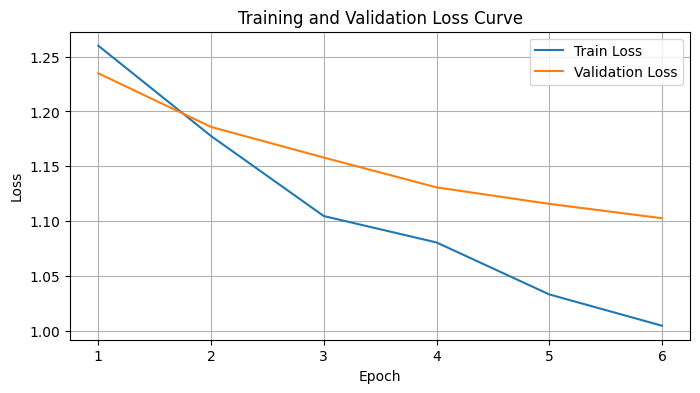

In [54]:
loss_plot(train_losses, val_losses)

In [55]:
for param in model0.features[7].parameters():
    param.requires_grad = True
for param in model0.features[8].parameters():
    param.requires_grad = True

In [56]:
print_frozen_layers(model0)

1. Слой 'features.0.0.weight' заморожен
2. Слой 'features.0.1.weight' заморожен
3. Слой 'features.0.1.bias' заморожен
4. Слой 'features.1.0.block.0.0.weight' заморожен
5. Слой 'features.1.0.block.0.1.weight' заморожен
6. Слой 'features.1.0.block.0.1.bias' заморожен
7. Слой 'features.1.0.block.1.fc1.weight' заморожен
8. Слой 'features.1.0.block.1.fc1.bias' заморожен
9. Слой 'features.1.0.block.1.fc2.weight' заморожен
10. Слой 'features.1.0.block.1.fc2.bias' заморожен
11. Слой 'features.1.0.block.2.0.weight' заморожен
12. Слой 'features.1.0.block.2.1.weight' заморожен
13. Слой 'features.1.0.block.2.1.bias' заморожен
14. Слой 'features.2.0.block.0.0.weight' заморожен
15. Слой 'features.2.0.block.0.1.weight' заморожен
16. Слой 'features.2.0.block.0.1.bias' заморожен
17. Слой 'features.2.0.block.1.0.weight' заморожен
18. Слой 'features.2.0.block.1.1.weight' заморожен
19. Слой 'features.2.0.block.1.1.bias' заморожен
20. Слой 'features.2.0.block.2.fc1.weight' заморожен
21. Слой 'features.2.0.

## **5. Тестирование модели**

Теперь можно протестировать нашу модель на тестовой выборке. Заодно сравним `best_model.pth` и `final_model.pth`.

In [182]:
# Загрузка сохраненных весов
def load_w(model):
    model.eval()  # Переводим модель в режим оценки

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return all_labels, all_preds

In [183]:
# Метрики
def metrics(all_labels, all_preds, name):
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')

    print(f'''
== {name}_model =================
Test Accuracy: {accuracy:.4f}
Test F1-Score: {f1:.4f}
Test Recall: {recall:.4f}''')

    # with open(f'test_results_{name}.txt', 'w') as f:
    #     f.write(f"Accuracy: {accuracy:.4f}\n")
    #     f.write(f"F1-Score: {f1:.4f}\n")
    #     f.write(f"Recall: {recall:.4f}\n")
    
    pass

In [257]:
# Confusion Matrix
def conf_matrix(all_labels, all_preds):

    class_names = ["Blazer", "Coat", "Dress", "Hoodie", "Jacket",
        "Jaket_Denim", "Jacket_Sports", "Jeans", "Pants", "Polo",
        "Shirt", "Shorts", "Skirt", "T-shirt", "Sweater"]
    
    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.savefig(f'''confusion_matrix.png''')
    plt.show()
    
    pass

In [329]:
# Список наиболее путающихся классов
import pandas as pd

def most_confused(all_labels, all_preds):
    class_names = ["Blazer", "Coat", "Dress", "Hoodie", "Jacket",
                   "Jaket_Denim", "Jacket_Sports", "Jeans", "Pants", "Polo",
                   "Shirt", "Shorts", "Skirt", "T-shirt", "Sweater"]

    count_dict = defaultdict(int)

    for actual, predicted in zip(all_labels, all_preds):
        count_dict[(actual, predicted)] += 1

    data = []
    for (actual, predicted), amount in count_dict.items():
        data.append((actual, predicted, amount))

    df = pd.DataFrame(data, columns=['actual', 'predicted', 'amount'])

    df['actual'] = df['actual'].apply(lambda x: class_names[x])
    df['predicted'] = df['predicted'].apply(lambda x: class_names[x])

    df_cleared = df[df['actual'] != df['predicted']]

    df_sorted = df_cleared.sort_values(by='amount', ascending=False)

    df_sorted = df_sorted.reset_index(drop=True)

    return df_sorted

In [ ]:
model0.load_state_dict(torch.load('final_model.pth'))
final_all_labels, final_all_preds = load_w(model0)

model0.load_state_dict(torch.load('best_model.pth'))
best_all_labels, best_all_preds = load_w(model0)

In [260]:
metrics(final_all_labels, final_all_preds, 'final')
metrics(best_all_labels, best_all_preds, 'best')


== final_model =================
Test Accuracy: 0.6726
Test F1-Score: 0.6723
Test Recall: 0.6726

== best_model =================
Test Accuracy: 0.6758
Test F1-Score: 0.6755
Test Recall: 0.6758


По метрикам best_model лучше, чем final_model, что и ожидалось. Давайте посмотрим матрицу ошибок для best_model.

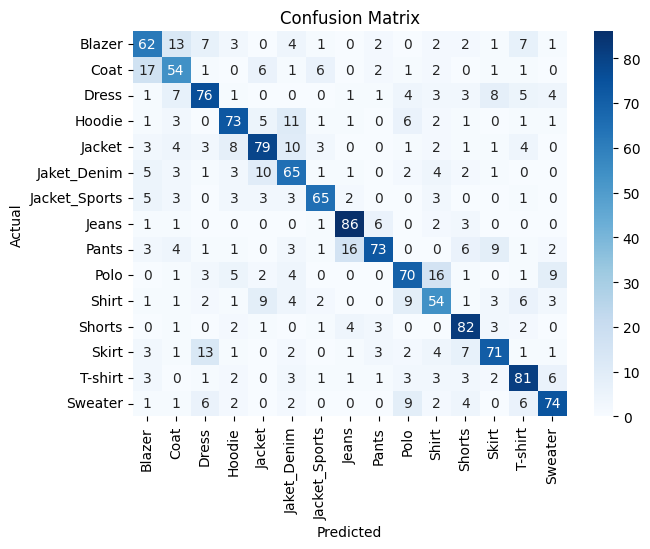

In [261]:
conf_matrix(best_all_labels, best_all_preds)

Теперь посмотрим где чаще всего путается модель.

In [264]:
most_confused(best_all_labels, best_all_preds)

,actual,predicted,amount
0,Coat,Blazer,17
1,Polo,Shirt,16
2,Pants,Jeans,16
3,Skirt,Dress,13
4,Blazer,Coat,13
...,...,...,...
147,Jaket_Denim,Dress,1
148,Hoodie,Blazer,1
149,Sweater,Coat,1
150,Dress,Blazer,1


## **6. Улучшение модели**

#### **Аугментация**

Добавим ещё один вид аугментации. `CutMix` — это метод, который вырезает патчи из одного изображения и вставляет их в другое. Это сохраняет целостность исходных изображений и создает более разнообразные тренировочные образцы. Метки также корректируются в соответствии с площадью вырезанного патча.

In [ ]:
def cutmix_data(x, y, alpha=1.0):
    '''__________________________________________________________________________

    torch.randperm(batch_size) создает случайную перестановку индексов от 0 до batch_size - 1.
    Это используется для перемешивания изображений и их меток.
    shuffled_x и shuffled_y - это перемешанные версии исходного батча x и меток y.
    __________________________________________________________________________'''

    batch_size, _, height, width = x.size()
    indices = torch.randperm(batch_size)
    shuffled_x = x[indices]
    shuffled_y = y[indices]

    '''__________________________________________________________________________

    lam - это параметр, который определяет, насколько сильно будет смешано изображение.
    Он выбирается из бета-распределения с параметрами alpha и alpha. Чем больше alpha,
    тем более равномерно будет распределено значение lam.
    __________________________________________________________________________'''

    lam = np.random.beta(alpha, alpha)
    cut_ratio = np.sqrt(1 - lam) # Определяет размер вырезаемой области. 
    cut_width = int(width * cut_ratio)
    cut_height = int(height * cut_ratio)

    # Cлучайные координаты центра вырезаемой области
    cx = np.random.randint(width)
    cy = np.random.randint(height)
    # Левый верхнйи и правый нижний углы
    x1 = int(np.clip(cx - cut_width // 2, 0, width))
    y1 = int(np.clip(cy - cut_height // 2, 0, height))
    x2 = int(np.clip(cx + cut_width // 2, 0, width))
    y2 = int(np.clip(cy + cut_height // 2, 0, height))

    mixed_x = x.clone()
    mixed_x[:, :, y1:y2, x1:x2] = shuffled_x[:, :, y1:y2, x1:x2]
    lam = 1 - ((x2 - x1) * (y2 - y1) / (width * height))
    mixed_y = y * lam + shuffled_y * (1 - lam)

    return mixed_x, mixed_y

#### **Разморозка слоёв**

Разморозим последние несколько слоёв EfficientNet-B0. Это позволит модели адаптироваться к нашим данным, не переобучаясь.

In [ ]:
model.load_state_dict(torch.load('best_model.pth'))

for param in model.features[7].parameters():
    param.requires_grad = True
for param in model.features[8].parameters():
    param.requires_grad = True

Используем меньший learning rate для дообучения.

In [ ]:
optimizer = optim.SGD(filter(lambda p: p.requires_grad,
                             model0.parameters()),
                             lr=0.0001,
                             momentum=0.9,
                             weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, min_lr=1e-6)

In [ ]:
writer_finetune = SummaryWriter('runs/clothes_classification_finetune')

best_val_loss = float('inf')

Теперь мы можем дообучить модель на 10 эпохах

In [ ]:
for epoch in range(10):
    model0.train()
    running_loss = 0.0
    running_accuracy = 0.0

    train_loop = tqdm(train_loader, desc=f"Fine-tuning Epoch {epoch + 1}/10", leave=False)
    for inputs, labels in train_loop:
        
        # Преобразуем метки в one-hot encoded формат
        labels_one_hot = torch.nn.functional.one_hot(labels, num_classes=15).float()
        
        # Применяем CutMix
        inputs, labels_mixed = cutmix_data(inputs, labels_one_hot)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        # Преобразуем mixed метки обратно в индексы классов
        labels_indices = labels_mixed.argmax(dim=1)
        
        # Вычисляем loss
        loss = criterion(outputs, labels_indices)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        running_loss += loss.item()
        running_accuracy += accuracy_score(labels_indices.cpu().numpy(), outputs.argmax(dim=1).cpu().numpy())
        train_loop.set_postfix(loss=loss.item())

    train_loss = running_loss / len(train_loader)
    train_accuracy = running_accuracy / len(train_loader)

    # Валидация
    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_accuracy += accuracy_score(labels.cpu().numpy(), outputs.argmax(dim=1).cpu().numpy())

    val_loss /= len(val_loader)
    val_accuracy /= len(val_loader)

    # Логирование в TensorBoard
    writer_finetune.add_scalar('Loss/Train (Fine-tuning)', train_loss, epoch)
    writer_finetune.add_scalar('Accuracy/Train (Fine-tuning)', train_accuracy, epoch)
    writer_finetune.add_scalar('Loss/Validation (Fine-tuning)', val_loss, epoch)
    writer_finetune.add_scalar('Accuracy/Validation (Fine-tuning)', val_accuracy, epoch)

    # Обновление шедулера
    scheduler.step(val_loss)

    # Ранняя остановка
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), 'best_model_finetuned.pth')
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= early_stopping_patience:
            print(f"Ранняя остановка на эпохе {epoch + 1}")
            break

    print(f"Fine-tuning Epoch {epoch + 1}/10")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Закрываем writer для улучшенного обучения
writer_finetune.close()

# Сохранение финальной модели
torch.save(model.state_dict(), 'final_model_finetuned.pth')

Fine-tuning Epoch 1/10
Train Loss: 1.8750, Train Accuracy: 0.4428
Validation Loss: 0.8343, Validation Accuracy: 0.7483


Fine-tuning Epoch 2/10
Train Loss: 1.9150, Train Accuracy: 0.4358
Validation Loss: 0.8286, Validation Accuracy: 0.7452


Fine-tuning Epoch 3/10
Train Loss: 1.7683, Train Accuracy: 0.4591
Validation Loss: 0.8578, Validation Accuracy: 0.7430


Fine-tuning Epoch 4/10
Train Loss: 1.8883, Train Accuracy: 0.4389
Validation Loss: 0.8391, Validation Accuracy: 0.7468


Fine-tuning Epoch 5/10
Train Loss: 1.7836, Train Accuracy: 0.4572
Validation Loss: 0.8061, Validation Accuracy: 0.7533


Fine-tuning Epoch 6/10
Train Loss: 1.8816, Train Accuracy: 0.4365
Validation Loss: 0.8417, Validation Accuracy: 0.7515


Fine-tuning Epoch 7/10
Train Loss: 1.8037, Train Accuracy: 0.4552
Validation Loss: 0.8470, Validation Accuracy: 0.7474


Fine-tuning Epoch 8/10
Train Loss: 1.8347, Train Accuracy: 0.4540
Validation Loss: 0.8229, Validation Accuracy: 0.7471


Fine-tuning Epoch 9/10
Train Loss: 1.8354, Train Accuracy: 0.4429
Validation Loss: 0.8197, Validation Accuracy: 0.7518


Ранняя остановка на эпохе 10


In [159]:
for epoch in range(10):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0

    train_loop = tqdm(train_loader, desc=f"Fine-tuning Epoch {epoch + 1}/10", leave=False)
    for inputs, labels in train_loop:
        
        labels_one_hot = torch.nn.functional.one_hot(labels, num_classes=15).float()
        
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        labels_indices = labels 
        
        # Вычисляем loss
        loss = criterion(outputs, labels_indices)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        running_loss += loss.item()
        running_accuracy += accuracy_score(labels_indices.cpu().numpy(), outputs.argmax(dim=1).cpu().numpy())
        train_loop.set_postfix(loss=loss.item())

    train_loss = running_loss / len(train_loader)
    train_accuracy = running_accuracy / len(train_loader)

    # Валидация
    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_accuracy += accuracy_score(labels.cpu().numpy(), outputs.argmax(dim=1).cpu().numpy())

    val_loss /= len(val_loader)
    val_accuracy /= len(val_loader)

    # Логирование в TensorBoard
    writer_finetune.add_scalar('Loss/Train (Fine-tuning)', train_loss, epoch)
    writer_finetune.add_scalar('Accuracy/Train (Fine-tuning)', train_accuracy, epoch)
    writer_finetune.add_scalar('Loss/Validation (Fine-tuning)', val_loss, epoch)
    writer_finetune.add_scalar('Accuracy/Validation (Fine-tuning)', val_accuracy, epoch)

    # Обновление шедулера
    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model_finetuned.pth')

    print(f"Fine-tuning Epoch {epoch + 1}/10")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

writer_finetune.close()

torch.save(model.state_dict(), 'final_model_finetuned.pth')

Fine-tuning Epoch 1/10
Train Loss: 0.9471, Train Accuracy: 0.6984
Validation Loss: 0.7423, Validation Accuracy: 0.7696


Fine-tuning Epoch 2/10
Train Loss: 0.9435, Train Accuracy: 0.7086
Validation Loss: 0.7444, Validation Accuracy: 0.7673


Fine-tuning Epoch 3/10
Train Loss: 0.9432, Train Accuracy: 0.6993
Validation Loss: 0.7467, Validation Accuracy: 0.7679


Fine-tuning Epoch 4/10
Train Loss: 0.9495, Train Accuracy: 0.6980
Validation Loss: 0.7393, Validation Accuracy: 0.7696


Fine-tuning Epoch 5/10
Train Loss: 0.9519, Train Accuracy: 0.6974
Validation Loss: 0.7549, Validation Accuracy: 0.7664


Fine-tuning Epoch 6/10
Train Loss: 0.9488, Train Accuracy: 0.6974
Validation Loss: 0.7475, Validation Accuracy: 0.7689


Fine-tuning Epoch 7/10
Train Loss: 0.9474, Train Accuracy: 0.6972
Validation Loss: 0.7452, Validation Accuracy: 0.7752


Fine-tuning Epoch 8/10
Train Loss: 0.9383, Train Accuracy: 0.7019
Validation Loss: 0.7488, Validation Accuracy: 0.7654


Fine-tuning Epoch 9/10
Train Loss: 0.9343, Train Accuracy: 0.7049
Validation Loss: 0.7366, Validation Accuracy: 0.7639


Fine-tuning Epoch 10/10
Train Loss: 0.9381, Train Accuracy: 0.7006
Validation Loss: 0.7348, Validation Accuracy: 0.7777


## **7. Повторное тестирование модели**

In [160]:
# model.load_state_dict(torch.load('final_model_finetuned.pth'))
# final_finetuned_all_preds, final_finetuned_all_labels = load_w(model)

model.load_state_dict(torch.load('best_model_finetuned0.pth'))
best_finetuned0_all_preds, best_finetuned0_all_labels = load_w(model)

model.load_state_dict(torch.load('best_model_finetuned.pth'))
best_finetuned_all_preds, best_finetuned_all_labels = load_w(model)

In [161]:
# metrics(final_finetuned_all_preds, final_finetuned_all_labels, 'final')
metrics(best_finetuned0_all_preds, best_finetuned0_all_labels, 'best')
metrics(best_finetuned_all_preds, best_finetuned_all_labels, 'best')


== best_model =================
Test Accuracy: 0.7373
Test F1-Score: 0.7353
Test Recall: 0.7373

== best_model =================
Test Accuracy: 0.7652
Test F1-Score: 0.7630
Test Recall: 0.7652


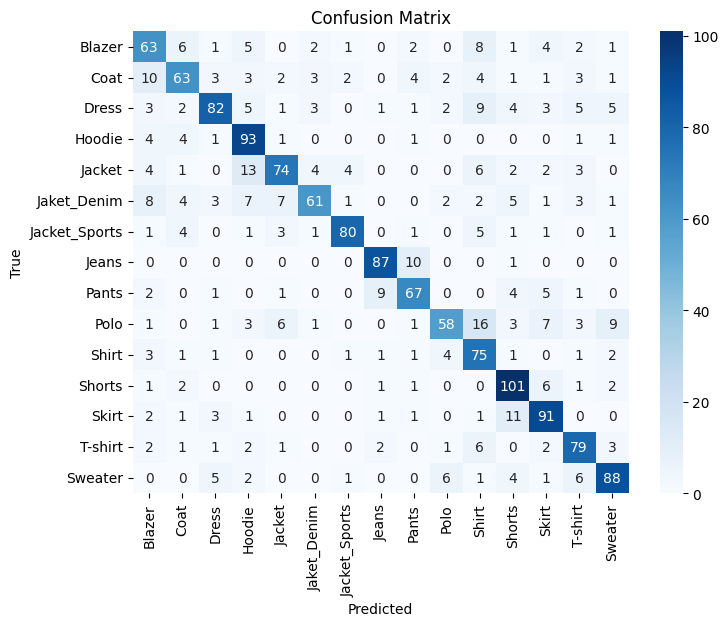

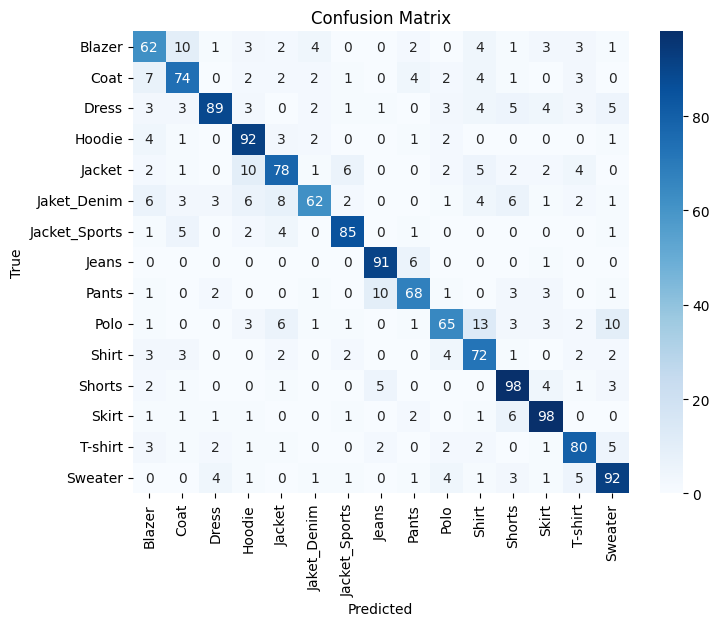

In [162]:
# conf_matrix(final_finetuned_all_preds, final_finetuned_all_labels, 'final')
conf_matrix(best_finetuned0_all_preds, best_finetuned0_all_labels, 'best')
conf_matrix(best_finetuned_all_preds, best_finetuned_all_labels, 'best')